In [1]:
import tensorflow as tf
import tensorlayer
import numpy as np
import os
import math
from PIL import Image
import glob
from tensorflow.python.framework import ops
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

/home/manideep/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Initializing all the images into 4d arrays.

filelist_trainx = glob.glob('trainx/*.jpg')
filelist_trainx.sort()
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = glob.glob('trainy/*.jpg')
filelist_trainy.sort()
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

filelist_testx = glob.glob('testx/*.jpg')
filelist_testx.sort()
X_test = np.array([np.array(Image.open(fname)) for fname in filelist_testx])

filelist_testy = glob.glob('testy/*.jpg')
filelist_testy.sort()
Y_test = np.array([np.array(Image.open(fname)) for fname in filelist_testy])

y = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


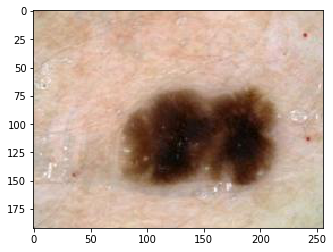

In [4]:
index = 125
plt.imshow(X_train[index])
print ("y = " + str(np.squeeze(Y_train[:, index])))

In [7]:
def lrelu(x, n, leak=0.2): 
    return tf.maximum(x, leak * x, name=n) 

In [8]:
def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf

    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, tf.zeros_like(out)], i)
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

In [9]:
def max_pool_2d( input, poolsize = 2):
    """
    A function executing max pooling with each feature map
    
    :type input: numpy.ndarray with 2 ot 3 dimension
    :params input: input feature maps ( #num_of_map, #width, #height)
    :type poolsize: int
    "param poolsize":  the downsampling (pooling) factor
    """
    assert input.ndim == 2 or input.ndim == 3

    if ( input.ndim ==3 ):
        num_of_map, width, height = input.shape

        output = np.zeros( ( num_of_map, width / poolsize, height / poolsize ) )
        switch_map = np.zeros( ( num_of_map, width / poolsize, height / poolsize ) )

        for map_index in xrange( input.shape[0] ):
            output[ map_index , :,  : ] , switch_map[ map_index, : , : ] = max_pool_2d( input[ map_index , : , : ] , poolsize )

    else:
        output = np.zeros( [ size / poolsize for size in input.shape ] )
        switch_map = np.zeros( [ size / poolsize for size in input.shape ] )

        for blocks_x in xrange( output.shape[0] ):
            for blocks_y in xrange( output.shape[1]):
                this_block = input[ ( blocks_x  ) * poolsize : ( blocks_x + 1  ) * poolsize,
                                               ( blocks_y  ) * poolsize : ( blocks_y + 1  ) * poolsize ]
                this_block = this_block.reshape( poolsize ** 2 )
                max_value = this_block.max()
                # np.where return a tuple yet what we need is its first element
                # whicw means if there are several max value , we take the first one
                max_index = np.where( this_block == max_value )[0][0]

                output[ blocks_x, blocks_y ] = max_value
                switch_map[ blocks_x, blocks_y ] = max_index

        return output , switch_map

    return output, switch_map


def max_uppool_2d( input, switch_map, poolsize = 2):
    """
    A function executing max uppooling with each feature map
    
    :type input: numpy.ndarray with 3 dimension
    :params input: input feature maps ( #num_of_map, #width, #height)
    :type switch_map: numpy.ndarray with 2 or 3 dimension
    :params switch_map: maps that store original location of max value in each block
    :type poolsize: int
    "param poolsize":  the downsampling (pooling) factor
    """
    assert input.shape[-2:] == switch_map.shape[-2:]
    assert input.ndim == 2 or input.ndim == 3

    if input.ndim == 3:
        num_of_map, w_in, h_in = input.shape
        w_out = w_in * poolsize;
        h_out = h_in * poolsize;

        output = np.zeros( ( num_of_map, w_out, h_out ) )
        for map_index in xrange( output.shape[0]):
            output[ map_index, : ,: ] = max_uppool_2d( input[ map_index, : , : ],
                                                       switch_map[ map_index, : , : ], 
                                                        poolsize )
    else:
        output = np.zeros( [size*poolsize for size in input.shape] )
        for blocks_x in xrange( input.shape[0] ):
            for blocks_y in xrange( input.shape[1] ):
                index = switch_map[ blocks_x, blocks_y ]
                x_bias = int( index / poolsize )
                y_bias = int( index % poolsize )
                output[ blocks_x * poolsize + x_bias, blocks_y * poolsize + y_bias ] = input[ blocks_x, blocks_y ]

    return output

In [10]:
def UnPooling2x2ZeroFilled(x):
    
    out = tf.concat([x, tf.zeros_like(x)], 3)
    out = tf.concat([out, tf.zeros_like(out)], 2)

    sh = x.get_shape().as_list()
    if None not in sh[1:]:
        out_size = [-1, sh[1] * 2, sh[2] * 2, sh[3]]
        return tf.reshape(out, out_size)
    else:
        shv = tf.shape(x)
        ret = tf.reshape(out, tf.stack([-1, shv[1] * 2, shv[2] * 2, sh[3]]))
        return ret

In [11]:
def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def deconv(x, W_shape, b_shape, name, padding='SAME'):
    W = tf.Variable(tf.truncated_normal(W_shape, stddev=0.03))
    b = tf.Variable(tf.truncated_normal([b_shape], stddev=0.03))

    x_shape = x.shape
    out_shape = tf.stack([x_shape[0], x_shape[1], x_shape[2], W_shape[2]])
    
    dconv = tf.nn.conv2d_transpose(x, W, out_shape, [1, 1, 1, 1], padding=padding) + b
    
    return tf.nn.relu(tf.contrib.layers.batch_norm(dconv, epsilon=1e-5, decay = 0.9,  updates_collections=None))


In [12]:
# Jaccard Loss Function

def jaccard_loss(output, target, axis=(0, 1, 2), smooth=1e-5):
    
    inse = tf.reduce_sum(output * target, axis=axis)
    
    l = tf.reduce_sum(output * output, axis=axis)
    r = tf.reduce_sum(target * target, axis=axis)
    
    jaccard = 1- (inse + smooth) / (l + r - inse + smooth)
    jaccard = tf.reduce_mean(jaccard)

    return jaccard


In [13]:
def random_mini_batches(X, Y, mini_batch_size = 16, seed = 0):
    """
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [14]:
def create_placeholders(n_H0, n_W0, n_C0):
    

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32, [16, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [16, n_H0, n_W0])
    ### END CODE HERE ###
    
    return X, Y

In [15]:
# Convolution Layers

def convolution(X):
    if True:
        
        #First Conv Layer
        W_conv1 = tf.get_variable('wconv1', [3, 3, 3, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('bconv1', [16], initializer=tf.constant_initializer(0))
        conv1 =  conv2d(X, W_conv1) + b_conv1
        bn1 = tf.contrib.layers.batch_norm(conv1, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn1')
        h_conv1 = tf.nn.relu(bn1)

        #Second Conv and Pool Layers
        W_conv2 = tf.get_variable('wconv2', [3, 3, 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('bconv2', [32], initializer=tf.constant_initializer(0))
        conv2 =  conv2d(h_conv1, W_conv2) + b_conv2
        bn2 = tf.contrib.layers.batch_norm(conv2, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn2')
        h_conv2 = tf.nn.relu(bn2)
        
        h_pool2 = avg_pool_2x2(h_conv2)
        
        #third Conv Layer
        W_conv3 = tf.get_variable('wconv3', [3, 3, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv3 = tf.get_variable('bconv3', [64], initializer=tf.constant_initializer(0))
        conv3 =  conv2d(h_pool2, W_conv3) + b_conv3
        bn3 = tf.contrib.layers.batch_norm(conv3, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn3')
        h_conv3 = tf.nn.relu(bn3)

        #fourth Conv and Pool Layers
        W_conv4 = tf.get_variable('wconv4', [3, 3, 64, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv4 = tf.get_variable('bconv4', [64], initializer=tf.constant_initializer(0))
        conv4 =  conv2d(h_conv3, W_conv4) + b_conv4
        bn4 = tf.contrib.layers.batch_norm(conv4, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn4')
        h_conv4 = tf.nn.relu(bn4)
        
        h_pool4 = avg_pool_2x2(h_conv4)
        
        #fifth Conv Layer
        W_conv5 = tf.get_variable('wconv5', [3, 3, 64, 128], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv5 = tf.get_variable('bconv5', [128], initializer=tf.constant_initializer(0))
        conv5 =  conv2d(h_pool4, W_conv5) + b_conv5
        bn5 = tf.contrib.layers.batch_norm(conv5, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn5')
        h_conv5 = tf.nn.relu(bn5)

        #sixth Conv and Pool Layers
        W_conv6 = tf.get_variable('wconv6', [4, 4, 128, 128], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv6 = tf.get_variable('bconv6', [128], initializer=tf.constant_initializer(0))
        conv6 =  conv2d(h_conv5, W_conv6) + b_conv6
        bn6 = tf.contrib.layers.batch_norm(conv6, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn6')
        h_conv6 = tf.nn.relu(bn6)
        
        h_pool6 = avg_pool_2x2(h_conv6)
        
        #seventh Conv Layer with Dropout of 0.5
        W_conv7 = tf.get_variable('wconv7', [3, 3, 128, 256], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv7 = tf.get_variable('bconv7', [256], initializer=tf.constant_initializer(0))
        conv7 =  conv2d(h_pool6, W_conv7) + b_conv7
        drop_out1 = tf.nn.dropout(conv7, 0.5)
        bn7 = tf.contrib.layers.batch_norm(drop_out1, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn7')
        h_conv7 = tf.nn.relu(bn7)

        #eigth Conv and Pool Layers
        W_conv8 = tf.get_variable('wconv8', [3, 3, 256, 256], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv8 = tf.get_variable('bconv8', [256], initializer=tf.constant_initializer(0))
        conv8 =  conv2d(h_conv7, W_conv8) + b_conv8
        bn8 = tf.contrib.layers.batch_norm(conv8, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn8')
        h_conv8 = tf.nn.relu(bn8)
        
        h_pool8 = avg_pool_2x2(h_conv8)
        
        #ninth Conv Layer
        W_conv9 = tf.get_variable('wconv9', [3, 3, 256, 512], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv9 = tf.get_variable('bconv9', [512], initializer=tf.constant_initializer(0))
        conv9 =  conv2d(h_pool8, W_conv9) + b_conv9
        bn9 = tf.contrib.layers.batch_norm(conv9, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn9')
        h_conv9 = tf.nn.relu(bn9) 
        
        #First fully connected layer
        W_fc1 = tf.get_variable('W_fc1', [7, 7, 512, 4096], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('b_fc1', [4096], initializer=tf.constant_initializer(0))
        fc1 =  conv2d(h_conv9, W_fc1) + b_fc1
        fc_bn1 = tf.contrib.layers.batch_norm(fc1, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='fc_bn1')
        h_fc1 = tf.nn.relu(fc_bn1)
        
        #Second fully connected layer
        W_fc2 = tf.get_variable('W_fc2', [1, 1, 4096, 4096], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('b_fc2', [4096], initializer=tf.constant_initializer(0))
        fc2 =  conv2d(h_fc1, W_fc2) + b_fc2
        fc_bn2 = tf.contrib.layers.batch_norm(fc2, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='fc_bn2')
        h_fc2 = tf.nn.relu(fc_bn2) 
        
        return h_fc2

In [16]:
# Deconvolution Layers

def deconvolution(X):
    if True:
        
        #Deconvolution Layers
        
        dconv1 = deconv(X, [3, 3, 256, 4096], 256, 'dconv1')
        
        dconv1_unpool = UnPooling2x2ZeroFilled(dconv1)
        #dconv1_unpool = deconv(dconv1, [3, 3, 256, 256], 256, 'dconv1_unpool')
        #dconv1_unpool = max_uppool_2d(dconv1, switch_map8)
        
        dconv2 = deconv(dconv1_unpool, [3, 3, 256, 256], 256, 'dconv2')
        dconv3 = deconv(dconv2, [3, 3, 128, 256], 128, 'dconv3')
        
        dconv3_unpool = UnPooling2x2ZeroFilled(dconv3)
        #dconv3_unpool = deconv(dconv3, [3, 3, 128, 128], 128, 'dconv3_unpool')
        #dconv3_unpool = max_uppool_2d(dconv3, switch_map6)
        
        dconv4 = deconv(dconv3_unpool, [4, 4, 128, 128], 128, 'dconv4')
        dconv5 = deconv(dconv4, [3, 3, 128, 128], 128, 'dconv5')
        
        dconv5_unpool = UnPooling2x2ZeroFilled(dconv5)
        #dconv5_unpool = deconv(dconv5, [3, 3, 128, 128], 128, 'dconv5_unpool')
        #dconv5_unpool = max_uppool_2d(dconv5, switch_map4)
        
        dconv6 = deconv(dconv5_unpool, [3, 3, 64, 128], 64, 'dconv6')
        dconv7 = deconv(dconv6, [3, 3, 32, 64], 32, 'dconv7')
        
        dconv7_unpool = UnPooling2x2ZeroFilled(dconv7)
        #dconv7_unpool = deconv(dconv7, [3, 3, 32, 32], 32, 'dconv7_unpool')
        #dconv7_unpool = max_uppool_2d(dconv7, switch_map2)
        
        dconv8 = deconv(dconv7_unpool, [3, 3, 16, 32], 16, 'dconv8')
        drop_out2 =  tf.nn.dropout(dconv8, 0.5)
        output = deconv(dconv8, [1, 1, 1, 16], 1, 'dconv9')
        return tf.reshape(output, (16,192,256))

In [17]:
def model(X_train, Y_train, X_test, Y_test, learning_rate= 1e-5, num_epochs=300, minibatch_size=16, reuse=False, print_cost = True):
    with tf.variable_scope('model') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        
        tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
        seed = 3                                          # to keep results consistent (numpy seed)
        (m, n_H0, n_W0, n_C0) = X_train.shape             
                                    
        costs = []                                        # To keep track of the cost
        
        X, Y = create_placeholders(n_H0, n_W0, n_C0)
        
        convol = convolution(X)
        output = deconvolution(convol)
        
        # Jaccard Loss Function
        cost = jaccard_loss(output, Y)
        
        # Jaccard loss function from the function defined above
        #loss = jaccard_loss(output, Y)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
        
        # Initialize all the variables globally
        init = tf.global_variables_initializer()
     
        # Start the session to compute the tensorflow graph
        with tf.Session() as sess:
        
            # Run the initialization
            sess.run(init)
        
            # Do the training loop
            for epoch in range(num_epochs):
                
                minibatch_cost = 0
                num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
                seed = seed + 1
                minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
                
                for minibatch in minibatches:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch
                    #minibatch_X = process_data('trainx', 3)
                    #minibatch_Y = process_data('trainy', 1)
                    
                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                    
                    _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                    
                    minibatch_cost += temp_cost / num_minibatches
                    
                # Print the cost every epoch
                if print_cost == True and epoch % 5 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                if print_cost == True and epoch % 1 == 0:
                    costs.append(minibatch_cost)
                    
            # plot the cost
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

            # Calculate the correct predictions
            predict_op = tf.argmax(output)
            correct_prediction = tf.equal(predict_op, tf.argmax(Y))
        
            # Calculate accuracy on the test set
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            print(accuracy)
            train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
            test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
            print("Train Accuracy:", train_accuracy)
            print("Test Accuracy:", test_accuracy)
                
            return train_accuracy, test_accuracy, parameters
                

In [ ]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)